# Doodle CNN
A neural network to predict what was drawn, given 28x28 input picture pixel data\
Trained with quickdraw-dataset

In [1]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import zipfile
from contextlib import ExitStack
from datetime import datetime
import glob
from functools import partial
import json

## Get data from my drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %%capture
# # !unzip "./drive/MyDrive/doodleDataSmall/doodle-small-clean.zip"
# !unzip "./drive/MyDrive/doodleDataFull/doodle-full-clean-high-D.zip"

In [4]:
# filepaths are all file located in doodle-small dir
# filepaths = sorted([path.lower() for path in glob.glob("doodle-small-clean/*")])
filepaths = sorted([path.lower() for path in glob.glob("doodle-full-clean-high-d/*")])
class_names = sorted([path.split("/")[1].split(".")[0].lower() for path in filepaths])
print(filepaths[:3])
print(class_names[:3])

['doodle-full-clean-high-d/aircraft carrier.tfrecord', 'doodle-full-clean-high-d/airplane.tfrecord', 'doodle-full-clean-high-d/alarm clock.tfrecord']
['aircraft carrier', 'airplane', 'alarm clock']


In [5]:
class DoodleDataset:
  '''
    Create TFRecordDataset from filepaths
  '''
  def __init__(self, filepaths, shuffle_buffer_size, batch_size=128):
    self.filepaths = filepaths
    self.shuffle_buffer_size = shuffle_buffer_size
    self.batch_size = batch_size

  # parse serialized Example protobuf
  def preprocess(self, tfrecord):
    # to parse we need the feature description of the protobuf
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=""),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=1)
    }
    parsed_example = tf.io.parse_single_example(tfrecord, feature_description)
    image = tf.io.parse_tensor(parsed_example['image'], out_type=tf.uint8)
    # now reshape
    image = tf.reshape(image, [28, 28])
    return image, parsed_example['label']


  def create_dataset(self):
    # reading all filepaths in parallel
    dataset = tf.data.TFRecordDataset(self.filepaths, num_parallel_reads=len(self.filepaths))

    # shuffling
    dataset = dataset.shuffle(self.shuffle_buffer_size)

    # parse serialized Dataset
    dataset = dataset.map(self.preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(self.batch_size, drop_remainder=True)
    # be 1 batch ahead
    return dataset.prefetch(1)



In [6]:
# create doodle dataset object
# need good shuffling so set the shuffle buffer size very large (even though it takes longer)
doodle_dataset = DoodleDataset(filepaths, shuffle_buffer_size=10000)

# about 1 million examples in doodle-small
full_set = doodle_dataset.create_dataset()

test_and_val_set = full_set.take(100_000 // doodle_dataset.batch_size)

test_set = test_and_val_set.take(50_000 // doodle_dataset.batch_size)
val_set = test_and_val_set.skip(50_000 // doodle_dataset.batch_size)

# rest
train_set = full_set.skip(100_000 // doodle_dataset.batch_size)

Metal device set to: Apple M1 Pro


2023-01-22 08:45:29.288978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-22 08:45:29.289113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
train_set

<SkipDataset element_spec=(TensorSpec(shape=(128, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(128,), dtype=tf.int64, name=None))>

In [8]:
def create_dataset(filepath):
  # reading all filepaths in parallel
    dataset = tf.data.TFRecordDataset(filepath)
    
    dataset = dataset.shuffle(40000)

  # parse serialized Dataset
    dataset = dataset.map(doodle_dataset.preprocess)
  # be 1 batch ahead
    return dataset.prefetch(1)
  
datasets = []
for filepath in filepaths:
    dataset = create_dataset(filepath)
    datasets.append(dataset)

### Now that we have and can save and load from tfrecord files, lets see some example images that we loaded!

2023-01-22 08:45:31.865223: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


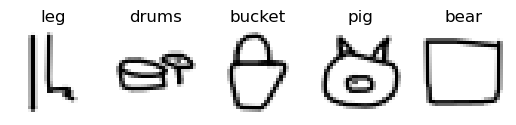

In [9]:
import matplotlib.pyplot as plt
for (X, y) in test_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        
        plt.axis("off")
        plt.title(class_names[y[i].numpy()])

## Step 2
Machine learning model

In [10]:
# clear session from possible previous models
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

### Architecture

Using Google's ResNet-34 Architecture

In [11]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.filters=filters
        self.strides=strides
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'strides': self.strides,
            'activation': self.activation,
        })
        return config

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [28]:
# creates a new partial class 'DefaultConv2D' with starting params of a keras.layers.Conv2D
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

model = keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(28, 28)))
model.add(tf.keras.layers.Rescaling(scale=1./255.))
model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)))
model.add(DefaultConv2D(64, kernel_size=7, strides=2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64

# 3 ResidualUnits with 64 feature maps, then 4 ResidualUnits with 128 feature maps, then . . .
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
# for filters in [64] * 1 + [128] * 2 + [256] * 3 + [512] * 2:
    strides = 1 if filters == prev_filters else 2
    # Max pool between different res unit "blocks"
    if (prev_filters != filters):
        model.add(keras.layers.MaxPool2D(pool_size=3, strides=1, padding="SAME"))
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation="relu"))
model.add(keras.layers.Dense(346, activation="softmax"))
 
    
    
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [29]:
# model_filepath = "/content/drive/MyDrive/doodleModelSmall/doodle_model_large.h5"
model_filepath = "./tmp/cp.ckpt"

# create log directory for tensorboard
logs = os.path.join(os.curdir, "my_logs", "run_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10, update_freq=10000)
# stop if model doesn't improve after 2 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2)
# save best model after each epoch
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=model_filepath,
                                                      save_best_only=True,
                                                      save_freq=50_000,
                                                      verbose=1,
                                                      save_weights_only=True,
                                                      monitor='accuracy')

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]



2023-01-22 09:15:26.954325: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-01-22 09:15:26.954366: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2023-01-22 09:15:26.954612: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


In [36]:
history = model.fit(train_set, epochs=20, verbose=1, validation_data=val_set, callbacks=callbacks)

Epoch 1/20
     10/Unknown - 4s 133ms/step - loss: 16.9852 - accuracy: 0.0484

2023-01-23 08:53:21.359419: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2023-01-23 08:53:21.359586: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2023-01-23 08:53:21.523344: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-23 08:53:21.529470: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2023-01-23 08:53:21.534559: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_logs/run_2023-01-22_09-15-26/plugins/profile/2023_01_23_08_53_21

2023-01-23 08:53:21.537268: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./my_logs/run_2023-01-22_09-15-26/plugins/profile/2023_01_23_08_53_21/Tates-MBP.lan.trace.json.gz
2023-01-23 08:53:21.542094: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_logs/run_2023-01-22_09-15-

    107/Unknown - 16s 123ms/step - loss: 5.3522 - accuracy: 0.3160

KeyboardInterrupt: 

In [35]:
model.save_weights('./checkpoints/my_checkpoint')

In [37]:
model.evaluate(test_set)

390/390 [==============================] - 8s 19ms/step - loss: 10.5080 - accuracy: 0.4750


[10.508007049560547, 0.4749799966812134]

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(346), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [ ]:
some = test_set.take(64)
predictions = []
test_labels = []
test_images = []
i=0
for (x, y) in some:
    p = model.predict(x[i])
    predictions.append(tf.reshape(p, (346)))
    test_labels.append(y[i])
    test_images.append(x[i])
    i+=1

In [ ]:
num_rows = 8
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()

In [ ]:

%load_ext tensorboard
%tensorboard --logdir=my_logs --port=6006

In [ ]:
model.save('doodle_small_ds_model')

In [ ]:
!zip -r doodle_small_ds_model.zip doodle_small_ds_model